# Impact of Indicator Metadata on Lifetime¶

In [1]:
# Import
import numpy as np
import pandas as pd 
from datetime import datetime
from datetime import timedelta
from IPython.display import HTML, display
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from tld import get_tld, get_fld
import category_encoders as ce
import re
from sklearn.model_selection import train_test_split

# Disable warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Color palette
sns.set_palette("rocket")
colors = sns.set_palette("rocket")

## General Malware Indicator Dataset

In [2]:
# Remove all rows without a last seen
urlData = pd.read_csv('.\Data\Threat_Fox\\threat_fox_urls.csv',sep=',', skipinitialspace=True)
urlData = urlData.loc[urlData["last_seen_utc"].notna()]

ipData = pd.read_csv('.\Data\Threat_Fox\\threat_fox_ip.csv',sep=',', skipinitialspace=True)
ipData = ipData.loc[ipData["last_seen_utc"].notna()]

hashData = pd.read_csv('.\Data\Threat_Fox\\threat_fox_md5.csv',sep=',', skipinitialspace=True)
hashData = hashData.loc[hashData["last_seen_utc"].notna()]

In [3]:
# Remove all rows where Indicator is younger then one year
present = datetime.now()
past = timedelta(days=31)
year = present - past

urlData["last_seen_utc"] = urlData["last_seen_utc"].apply(lambda x: pd.to_datetime(x))
urlData["first_seen_utc"] = urlData["first_seen_utc"].apply(lambda x: pd.to_datetime(x))
urlData = urlData[urlData["last_seen_utc"] < year]
urlData = urlData[urlData["last_seen_utc"] != urlData["first_seen_utc"]]

ipData["last_seen_utc"] = ipData["last_seen_utc"].apply(lambda x: pd.to_datetime(x))
ipData["first_seen_utc"] = ipData["first_seen_utc"].apply(lambda x: pd.to_datetime(x))
ipData = ipData[ipData["last_seen_utc"] < year]
ipData = ipData[ipData["last_seen_utc"] != ipData["first_seen_utc"]]

hashData["last_seen_utc"] = hashData["last_seen_utc"].apply(lambda x: pd.to_datetime(x))
hashData["first_seen_utc"] = hashData["first_seen_utc"].apply(lambda x: pd.to_datetime(x))
hashData = hashData[hashData["last_seen_utc"] < year]
hashData = hashData[hashData["last_seen_utc"] != hashData["first_seen_utc"]]

In [4]:
# Calculate lifetime and delete negative values
urlData['lifetimeHours'] = (urlData["last_seen_utc"] - urlData["first_seen_utc"]) / pd.Timedelta(hours=1)
urlData = urlData[urlData['lifetimeHours'] >= 0].dropna()

ipData['lifetimeHours'] = (ipData["last_seen_utc"] - ipData["first_seen_utc"]) / pd.Timedelta(hours=1)
ipData = ipData[ipData['lifetimeHours'] >= 0].dropna()

hashData['lifetimeHours'] = (hashData["last_seen_utc"] - hashData["first_seen_utc"]) / pd.Timedelta(hours=1)
hashData = hashData[hashData['lifetimeHours'] >= 0].dropna()

In [5]:
fullData = pd.concat([urlData, hashData, ipData], axis=0)
fullData.shape[0]

127448

In [6]:
fullData.reporter.value_counts()

Cryptolaemus1    82088
abuse_ch         15432
drb_ra            6990
thehappydinoa     4819
Rony              3289
                 ...  
Pitachu              1
netresec             1
Ishusoka             1
Xev                  1
aachum               1
Name: reporter, Length: 110, dtype: int64

In [7]:
fullData['num_reporter']=fullData['reporter'].astype('category').cat.codes
print(fullData["num_reporter"].corr(fullData["lifetimeHours"]))

0.27772681534094795


In [8]:
# Split1 = 50/50
split1_50_train, split1_50_test = train_test_split(fullData, test_size=0.5)

# Split1 = 70/30
split2_30_train, split2_70_test = train_test_split(fullData, test_size=0.7)

# Split1 = 30/70
split3_70_train, split3_30_test = train_test_split(fullData, test_size=0.3)

In [9]:
# Display information
average = [["split1_50_train Lifetime",split1_50_train["num_reporter"].corr(split1_50_train["lifetimeHours"])], 
           ["split1_50_test Lifetime",split1_50_test["num_reporter"].corr(split1_50_test["lifetimeHours"])], 
           ["split2_30_train Lifetime",split2_30_train["num_reporter"].corr(split2_30_train["lifetimeHours"])],
           ["split2_70_test Lifetime",split2_70_test["num_reporter"].corr(split2_70_test["lifetimeHours"])], 
           ["split3_70_train Lifetime",split3_70_train["num_reporter"].corr(split3_70_train["lifetimeHours"])],
            ["split3_30_test Lifetime",split3_30_test["num_reporter"].corr(split3_30_test["lifetimeHours"])]]

display(HTML(
   "<table><tr>{}</tr></table>".format(
       "</tr><tr>".join(
           "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in average))
))

split1_50_train Lifetime,0.276588721332104
split1_50_test Lifetime,0.2788751220001329
split2_30_train Lifetime,0.2783804279903015
split2_70_test Lifetime,0.2774471447738842
split3_70_train Lifetime,0.2787277107081927
split3_30_test Lifetime,0.27549214222321095


## URL APT Phishing Indicator Dataset

In [10]:
urlData = pd.read_csv(".\Data\\Phishing\VT_Submissions_Metadata.csv", sep=",", encoding='windows-1252')
# Separat sightings
urlData["sightings"] = urlData["sightings"].str.split("#")

# Remove all rows where the indicator is younger than 1 month
present = datetime.now()
past = timedelta(days=31)
year = present - past

urlData["Last Submission"] = urlData["Last Submission"].apply(lambda x: pd.to_datetime(x))
urlData["First Submission"] = urlData["First Submission"].apply(lambda x: pd.to_datetime(x))
urlData["lifetimeHours"] = (urlData["Last Submission"] - urlData["First Submission"]) / pd.Timedelta(hours=1)
urlData = urlData[urlData["Last Submission"] < year]
urlData = urlData[urlData["Last Submission"] != urlData["First Submission"]]
urlData = urlData[urlData['lifetimeHours'] >= 0].dropna()
urlData = urlData[urlData['Malicious'] != 0]

## Extension of the Data with Features

In [11]:
# Deleting the extension "WWW"
urlData['Indicator'] = urlData['Indicator'].replace('www.', '', regex=True)

## Adding SSL
urlData['ssl'] = np.where(urlData['Indicator'].str.contains("https", case=False), "https",
                       np.where(urlData['Indicator'].str.contains("http", case=False), "http", "?"))
urlData['Indicator'] = urlData['Indicator'].replace('http://', '', regex=True)
urlData['Indicator'] = urlData['Indicator'].replace('https://', '', regex=True)

# Adding length
urlData['length'] = urlData['Indicator'].apply(lambda x: len(str(x)))

# Adding domain
urlData['domain'] = urlData['Indicator'].apply(lambda x: get_fld(str(x), fix_protocol=True, fail_silently=True))
urlData['numDomain']=urlData['domain'].astype('category').cat.codes

## Adding Top-Level-Domain
#urlData['tld'] = urlData['ioc_value'].apply(lambda x: get_tld(str(x), fix_protocol=True, fail_silently=True))
urlData['numTld']=urlData['TLD'].astype('category').cat.codes

## Adding number of letters
urlData['letter'] = urlData['Indicator'].apply(lambda x: sum(char.isalpha() for char in x))

## Adding number of numbers
urlData['number'] = urlData['Indicator'].apply(lambda x: sum(char.isdigit() for char in x))

## Adding number of special characters
urlData['special'] = urlData['Indicator'].apply(lambda x: sum(char in "\-!@#$%^&*()_+-=[]{};:,.<>/?`~|" for char in x))

urlData.head()

,Unnamed: 0,Indicator,ID,Type,Threat Name,TLD,Last Submission,First Submission,Malicious,Harmless,sightings,lifetimeHours,ssl,length,domain,numDomain,numTld,letter,number,special
0,0,calendar-ua.firstcloudit.com,3744f508ffae357561e31e0a57d33336d82f71da7674cb...,url,['Mal/HTMLGen-A'],com,2024-10-06 01:45:00,2024-02-27 06:52:40,6,62,"[2024-10-06 01:45:00, 2024-10-05 23:25:43, 202...",5322.872222,?,28,firstcloudit.com,49,2,25,0,3
1,0,calendarua.firstcloudit.com,0a8ce89569d558d9fefcb4ab46c3a276fb59716a93cf44...,url,['Mal/HTMLGen-A'],com,2024-10-05 23:26:13,2024-02-27 06:52:44,5,63,"[2024-10-05 23:26:13, 2024-08-30 04:38:24, 202...",5320.558056,?,27,firstcloudit.com,49,2,25,0,2
2,0,dls-gov.firstcloudit.com,70ea1dc461e51cd37480afb52fd758218bfcedd95f4063...,url,[],com,2024-09-29 16:57:38,2024-02-27 06:52:37,7,62,"[2024-09-29 16:57:38, 2024-08-30 04:38:25, 202...",5170.083611,?,24,firstcloudit.com,49,2,21,0,3
3,0,e-gov-am.firstcloudit.com,e24501b97c978979be2c26ac0533cffec5eb7151595335...,url,[],com,2024-09-29 16:57:57,2023-11-27 18:12:56,6,61,"[2024-09-29 16:57:57, 2024-08-30 04:38:25, 202...",7366.750278,?,25,firstcloudit.com,49,2,21,0,4
4,0,e-gov.firstcloudit.com,af5fda8a5f3a352efb4d1dd69c3edc3e740bd59375099b...,url,[],com,2024-09-29 16:57:39,2024-02-27 06:52:43,6,61,"[2024-09-29 16:57:39, 2024-08-30 04:38:25, 202...",5170.082222,?,22,firstcloudit.com,49,2,19,0,3


## Spliting the Data

In [12]:
# Split1 = 50/50
split1_50_train, split1_50_test = train_test_split(urlData, test_size=0.5)

# Split1 = 70/30
split2_30_train, split2_70_test = train_test_split(urlData, test_size=0.7)

# Split1 = 30/70
split3_70_train, split3_30_test = train_test_split(urlData, test_size=0.3)

In [13]:
split3_70_train.shape

(209, 20)

<Axes: >

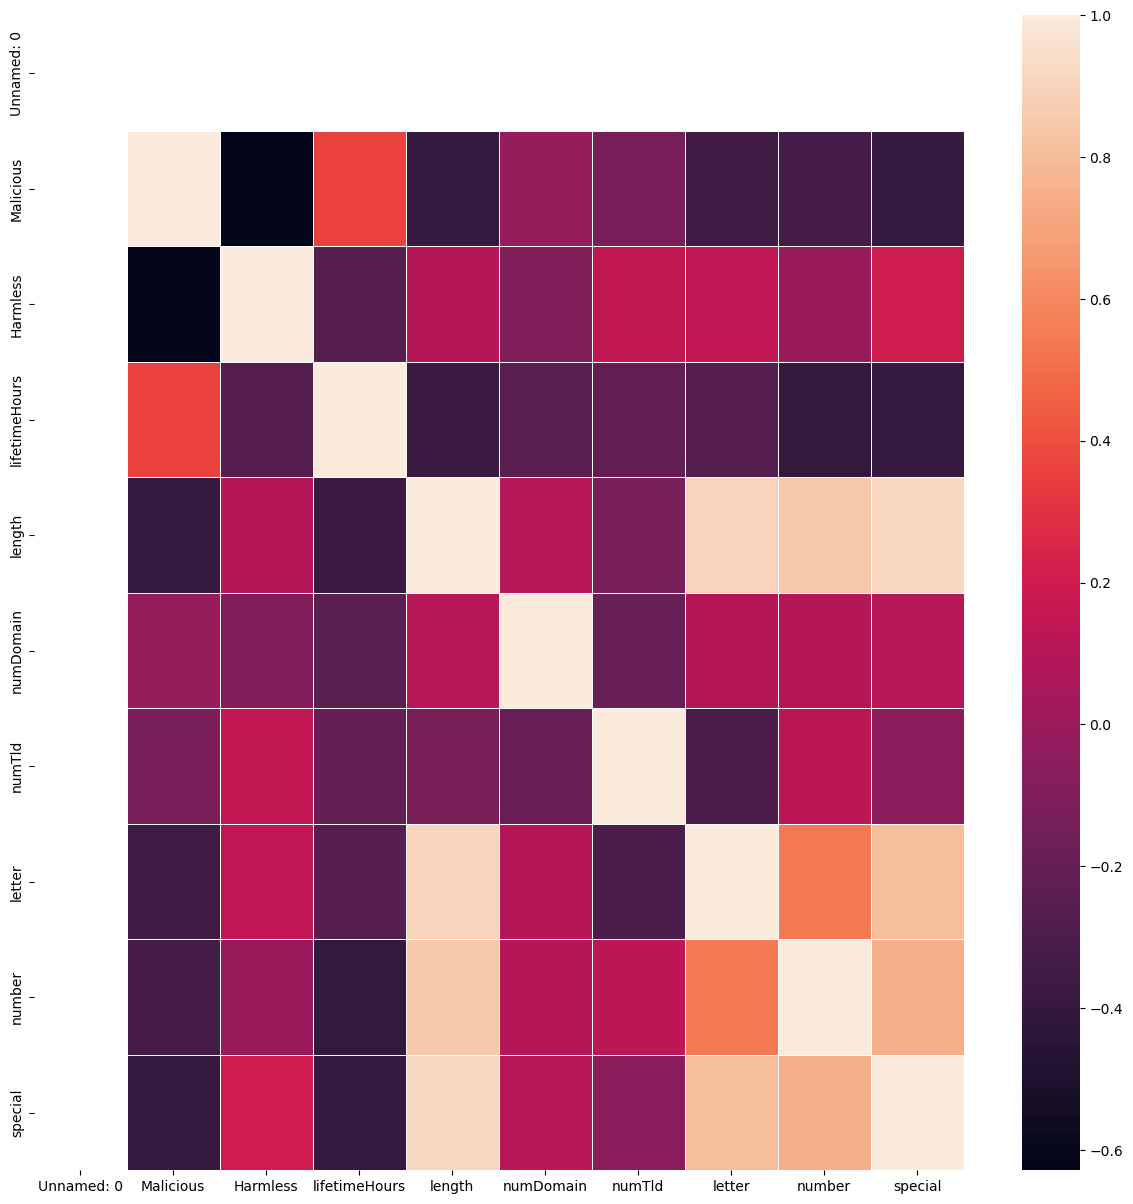

In [14]:
plt.figure(figsize=(15, 15))
sns.heatmap(urlData.corr(numeric_only=True), linewidths=.5)

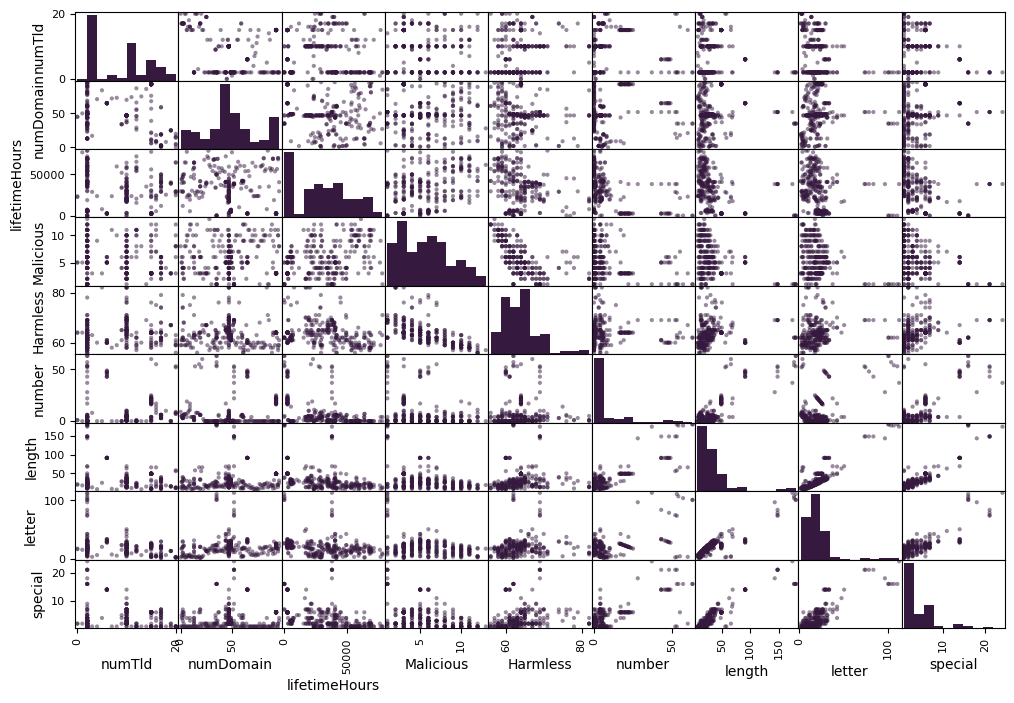

In [15]:
from pandas.plotting import scatter_matrix

attributes = ["numTld", "numDomain", "lifetimeHours", "Threat Name", "Malicious", "Harmless", "number", "length", "letter", "special"]
_ = scatter_matrix(urlData[attributes], figsize=(12,8))

In [16]:
# Display information
average = [["numTld Lifetime",urlData["numTld"].corr(urlData["lifetimeHours"])], 
           ["numDomain Lifetime",urlData["numDomain"].corr(urlData["lifetimeHours"])], 
           ["Malicious Lifetime",urlData["Malicious"].corr(urlData["lifetimeHours"])],
           ["Harmless Lifetime",urlData["Harmless"].corr(urlData["lifetimeHours"])], 
           ["number Lifetime",urlData["number"].corr(urlData["lifetimeHours"])],
            ["length Lifetime",urlData["length"].corr(urlData["lifetimeHours"])],
            ["letter Lifetime",urlData["letter"].corr(urlData["lifetimeHours"])],
            ["special Lifetime",urlData["special"].corr(urlData["lifetimeHours"])]]

display(HTML(
   "<table><tr>{}</tr></table>".format(
       "</tr><tr>".join(
           "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in average))
))

numTld Lifetime,-0.21430211551429362
numDomain Lifetime,-0.2428081482513308
Malicious Lifetime,0.3580233639963937
Harmless Lifetime,-0.26195409500512395
number Lifetime,-0.4053291931969764
length Lifetime,-0.37983186342080494
letter Lifetime,-0.2630981313688919
special Lifetime,-0.39562832058671576


## Correlation

### Test 1

In [17]:
# Display information Train 1
average = [["numDomain","Train:" + str(round(split1_50_train["lifetimeHours"].corr(split1_50_train["numDomain"]),2)) + 
            "; Test:" + str(round(split1_50_test["lifetimeHours"].corr(split1_50_test["numDomain"]),2)) + 
            "; Diff in %:" + str(round((split1_50_train["lifetimeHours"].corr(split1_50_train["numDomain"]) - split1_50_test["lifetimeHours"].corr(split1_50_test["numDomain"])) * 100 / split1_50_train["lifetimeHours"].corr(split1_50_train["numDomain"]),2))], 
["special","Train:" + str(round(split1_50_train["lifetimeHours"].corr(split1_50_train["special"]),2)) +
           "; Test:" + str(round(split1_50_test["lifetimeHours"].corr(split1_50_test["special"]),2)) + 
           "; Diff in %:" + str(round((split1_50_train["lifetimeHours"].corr(split1_50_train["special"]) - split1_50_test["lifetimeHours"].corr(split1_50_test["special"])) * 100 / split1_50_train["lifetimeHours"].corr(split1_50_train["special"]),2))], 
["number","Train:" + str(round(split1_50_train["lifetimeHours"].corr(split1_50_train["number"]),2)) +
           "; Test:" + str(round(split1_50_test["lifetimeHours"].corr(split1_50_test["number"]),2)) + 
           "; Diff in %:" + str(round((split1_50_train["lifetimeHours"].corr(split1_50_train["number"]) - split1_50_test["lifetimeHours"].corr(split1_50_test["number"])) * 100 / split1_50_train["lifetimeHours"].corr(split1_50_train["number"]),2))], 
["letter","Train:" + str(round(split1_50_train["lifetimeHours"].corr(split1_50_train["letter"]),2)) + 
           "; Test:" + str(round(split1_50_test["lifetimeHours"].corr(split1_50_test["letter"]),2)) + 
           "; Diff in %:" + str(round((split1_50_train["lifetimeHours"].corr(split1_50_train["letter"]) - split1_50_test["lifetimeHours"].corr(split1_50_test["letter"])) * 100 / split1_50_train["lifetimeHours"].corr(split1_50_train["letter"]),2))], 
["length","Train:" + str(round(split1_50_train["lifetimeHours"].corr(split1_50_train["length"]),2)) +
           "; Test:" + str(round(split1_50_test["lifetimeHours"].corr(split1_50_test["length"]),2)) + 
           "; Diff in %:" + str(round((split1_50_train["lifetimeHours"].corr(split1_50_train["length"]) - split1_50_test["lifetimeHours"].corr(split1_50_test["length"])) * 100 / split1_50_train["lifetimeHours"].corr(split1_50_train["length"]),2))], 
["Harmless","Train:" + str(round(split1_50_train["lifetimeHours"].corr(split1_50_train["Harmless"]),2)) +
           "; Test:" + str(round(split1_50_test["lifetimeHours"].corr(split1_50_test["Harmless"]),2)) + 
           "; Diff in %:" + str(round((split1_50_train["lifetimeHours"].corr(split1_50_train["Harmless"]) - split1_50_test["lifetimeHours"].corr(split1_50_test["Harmless"])) * 100 / split1_50_train["lifetimeHours"].corr(split1_50_train["Harmless"]),2))], 
["Malicious","Train:" + str(round(split1_50_train["lifetimeHours"].corr(split1_50_train["Malicious"]),2)) +
           "; Test:" + str(round(split1_50_test["lifetimeHours"].corr(split1_50_test["Malicious"]),2)) + 
           "; Diff in %:" + str(round((split1_50_train["lifetimeHours"].corr(split1_50_train["Malicious"]) - split1_50_test["lifetimeHours"].corr(split1_50_test["Malicious"])) * 100 / split1_50_train["lifetimeHours"].corr(split1_50_train["Malicious"]), 2))], 
]

display(HTML(
   "<table><tr>{}</tr></table>".format(
       "</tr><tr>".join(
           "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in average))
))

numDomain,Train:-0.29; Test:-0.2; Diff in %:29.2
special,Train:-0.44; Test:-0.35; Diff in %:20.53
number,Train:-0.46; Test:-0.34; Diff in %:25.68
letter,Train:-0.28; Test:-0.26; Diff in %:8.29
length,Train:-0.41; Test:-0.36; Diff in %:13.52
Harmless,Train:-0.27; Test:-0.27; Diff in %:-0.92
Malicious,Train:0.47; Test:0.26; Diff in %:45.07


### Test 2

In [18]:
# Display information Train 1
average = [["numDomain","Train:" + str(round(split2_30_train["lifetimeHours"].corr(split2_30_train["numDomain"]),2)) + 
            "; Test:" + str(round(split2_70_test["lifetimeHours"].corr(split2_70_test["numDomain"]),2)) + 
            "; Diff in %:" + str(round((split2_30_train["lifetimeHours"].corr(split2_30_train["numDomain"]) - split2_70_test["lifetimeHours"].corr(split2_70_test["numDomain"])) * 100 / split2_30_train["lifetimeHours"].corr(split2_30_train["numDomain"]),2))], 
["special","Train:" + str(round(split2_30_train["lifetimeHours"].corr(split2_30_train["special"]),2)) +
           "; Test:" + str(round(split2_70_test["lifetimeHours"].corr(split2_70_test["special"]),2)) + 
           "; Diff in %:" + str(round((split2_30_train["lifetimeHours"].corr(split2_30_train["special"]) - split2_70_test["lifetimeHours"].corr(split2_70_test["special"])) * 100 / split2_30_train["lifetimeHours"].corr(split2_30_train["special"]),2))], 
["number","Train:" + str(round(split2_30_train["lifetimeHours"].corr(split2_30_train["number"]),2)) +
           "; Test:" + str(round(split2_70_test["lifetimeHours"].corr(split2_70_test["number"]),2)) + 
           "; Diff in %:" + str(round((split2_30_train["lifetimeHours"].corr(split2_30_train["number"]) - split2_70_test["lifetimeHours"].corr(split2_70_test["number"])) * 100 / split2_30_train["lifetimeHours"].corr(split2_30_train["number"]),2))], 
["letter","Train:" + str(round(split2_30_train["lifetimeHours"].corr(split2_30_train["letter"]),2)) + 
           "; Test:" + str(round(split2_70_test["lifetimeHours"].corr(split2_70_test["letter"]),2)) + 
           "; Diff in %:" + str(round((split2_30_train["lifetimeHours"].corr(split2_30_train["letter"]) - split2_70_test["lifetimeHours"].corr(split2_70_test["letter"])) * 100 / split2_30_train["lifetimeHours"].corr(split2_30_train["letter"]),2))], 
["length","Train:" + str(round(split2_30_train["lifetimeHours"].corr(split2_30_train["length"]),2)) +
           "; Test:" + str(round(split2_70_test["lifetimeHours"].corr(split2_70_test["length"]),2)) + 
           "; Diff in %:" + str(round((split2_30_train["lifetimeHours"].corr(split2_30_train["length"]) - split2_70_test["lifetimeHours"].corr(split2_70_test["length"])) * 100 / split2_30_train["lifetimeHours"].corr(split2_30_train["length"]),2))], 
["Harmless","Train:" + str(round(split2_30_train["lifetimeHours"].corr(split2_30_train["Harmless"]),2)) +
           "; Test:" + str(round(split2_70_test["lifetimeHours"].corr(split2_70_test["Harmless"]),2)) + 
           "; Diff in %:" + str(round((split2_30_train["lifetimeHours"].corr(split2_30_train["Harmless"]) - split2_70_test["lifetimeHours"].corr(split2_70_test["Harmless"])) * 100 / split2_30_train["lifetimeHours"].corr(split2_30_train["Harmless"]),2))], 
["Malicious","Train:" + str(round(split2_30_train["lifetimeHours"].corr(split2_30_train["Malicious"]),2)) +
           "; Test:" + str(round(split2_70_test["lifetimeHours"].corr(split2_70_test["Malicious"]),2)) + 
           "; Diff in %:" + str(round((split2_30_train["lifetimeHours"].corr(split2_30_train["Malicious"]) - split2_70_test["lifetimeHours"].corr(split2_70_test["Malicious"])) * 100 / split2_30_train["lifetimeHours"].corr(split2_30_train["Malicious"]), 2))], 
]

display(HTML(
   "<table><tr>{}</tr></table>".format(
       "</tr><tr>".join(
           "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in average))
))

numDomain,Train:-0.31; Test:-0.22; Diff in %:29.05
special,Train:-0.39; Test:-0.4; Diff in %:-3.22
number,Train:-0.36; Test:-0.42; Diff in %:-15.59
letter,Train:-0.3; Test:-0.25; Diff in %:14.97
length,Train:-0.38; Test:-0.38; Diff in %:1.63
Harmless,Train:-0.16; Test:-0.31; Diff in %:-90.51
Malicious,Train:0.22; Test:0.41; Diff in %:-87.4


### Test 3

In [19]:
# Display information Train 1
average = [["numDomain","Train:" + str(round(split3_70_train["lifetimeHours"].corr(split3_70_train["numDomain"]),2)) + 
            "; Test:" + str(round(split3_30_test["lifetimeHours"].corr(split3_30_test["numDomain"]),2)) + 
            "; Diff in %:" + str(round((split3_70_train["lifetimeHours"].corr(split3_70_train["numDomain"]) - split3_30_test["lifetimeHours"].corr(split3_30_test["numDomain"])) * 100 / split3_70_train["lifetimeHours"].corr(split3_70_train["numDomain"]),2))], 
["special","Train:" + str(round(split3_70_train["lifetimeHours"].corr(split3_70_train["special"]),2)) +
           "; Test:" + str(round(split3_30_test["lifetimeHours"].corr(split3_30_test["special"]),2)) + 
           "; Diff in %:" + str(round((split3_70_train["lifetimeHours"].corr(split3_70_train["special"]) - split3_30_test["lifetimeHours"].corr(split3_30_test["special"])) * 100 / split3_70_train["lifetimeHours"].corr(split3_70_train["special"]),2))], 
["number","Train:" + str(round(split3_70_train["lifetimeHours"].corr(split3_70_train["number"]),2)) +
           "; Test:" + str(round(split3_30_test["lifetimeHours"].corr(split3_30_test["number"]),2)) + 
           "; Diff in %:" + str(round((split3_70_train["lifetimeHours"].corr(split3_70_train["number"]) - split3_30_test["lifetimeHours"].corr(split3_30_test["number"])) * 100 / split3_70_train["lifetimeHours"].corr(split3_70_train["number"]),2))], 
["letter","Train:" + str(round(split3_70_train["lifetimeHours"].corr(split3_70_train["letter"]),2)) + 
           "; Test:" + str(round(split3_30_test["lifetimeHours"].corr(split3_30_test["letter"]),2)) + 
           "; Diff in %:" + str(round((split3_70_train["lifetimeHours"].corr(split3_70_train["letter"]) - split3_30_test["lifetimeHours"].corr(split3_30_test["letter"])) * 100 / split3_70_train["lifetimeHours"].corr(split3_70_train["letter"]),2))], 
["length","Train:" + str(round(split3_70_train["lifetimeHours"].corr(split3_70_train["length"]),2)) +
           "; Test:" + str(round(split3_30_test["lifetimeHours"].corr(split3_30_test["length"]),2)) + 
           "; Diff in %:" + str(round((split3_70_train["lifetimeHours"].corr(split3_70_train["length"]) - split3_30_test["lifetimeHours"].corr(split3_30_test["length"])) * 100 / split3_70_train["lifetimeHours"].corr(split3_70_train["length"]),2))], 
["Harmless","Train:" + str(round(split3_70_train["lifetimeHours"].corr(split3_70_train["Harmless"]),2)) +
           "; Test:" + str(round(split3_30_test["lifetimeHours"].corr(split3_30_test["Harmless"]),2)) + 
           "; Diff in %:" + str(round((split3_70_train["lifetimeHours"].corr(split3_70_train["Harmless"]) - split3_30_test["lifetimeHours"].corr(split3_30_test["Harmless"])) * 100 / split3_70_train["lifetimeHours"].corr(split3_70_train["Harmless"]),2))], 
["Malicious","Train:" + str(round(split3_70_train["lifetimeHours"].corr(split3_70_train["Malicious"]),2)) +
           "; Test:" + str(round(split3_30_test["lifetimeHours"].corr(split3_30_test["Malicious"]),2)) + 
           "; Diff in %:" + str(round((split3_70_train["lifetimeHours"].corr(split3_70_train["Malicious"]) - split3_30_test["lifetimeHours"].corr(split3_30_test["Malicious"])) * 100 / split3_70_train["lifetimeHours"].corr(split3_70_train["Malicious"]), 2))], 
]

display(HTML(
   "<table><tr>{}</tr></table>".format(
       "</tr><tr>".join(
           "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in average))
))

numDomain,Train:-0.23; Test:-0.27; Diff in %:-16.74
special,Train:-0.35; Test:-0.54; Diff in %:-52.76
number,Train:-0.37; Test:-0.47; Diff in %:-28.42
letter,Train:-0.22; Test:-0.35; Diff in %:-56.53
length,Train:-0.33; Test:-0.48; Diff in %:-43.78
Harmless,Train:-0.21; Test:-0.37; Diff in %:-75.46
Malicious,Train:0.31; Test:0.45; Diff in %:-43.7
